In [1]:
import pandas as pd
import numpy as np
import glob, os
from tqdm import tqdm
import _thread
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [2]:
df = pd.read_csv('../data/DE30_EUR.2018_2019.M1', index_col=None, header=None)
df.columns = ['timestamp', 'Complete', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df[['timestamp','Open','High','Low', 'Close', 'Volume']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(['timestamp'])
df.head()

,Open,High,Low,Close,Volume
timestamp,,,,,
2018-01-02 07:00:00,12921.6,12923.6,12917.3,12922.8,101
2018-01-02 07:01:00,12923.2,12933.6,12923.0,12931.6,106
2018-01-02 07:02:00,12931.0,12933.0,12917.3,12917.6,121
2018-01-02 07:03:00,12917.1,12922.2,12916.0,12920.3,106
2018-01-02 07:04:00,12920.6,12925.3,12920.6,12925.3,52


In [3]:
df[['Close', 'Low', 'High']].to_numpy()[0][1]

12917.3

In [4]:
#set actions

minutes_to_look_forward = 10
tp = 6

price = df[['Close', 'Low', 'High']].to_numpy()
buy = []
sell = []
wait = []

for i in tqdm(range(len(df))):
    current_buy = 0
    current_sell = 0
    current_wait = 0
    for next_price in price[i+1:i+minutes_to_look_forward]:
        if current_buy == 0 and current_sell == 0:
            if next_price[2] - price[i][0] > tp:
                current_buy = 1
            if price[i][0] - next_price[1] > tp:
                current_sell = 1
            if current_buy == 1 and current_sell == 1:
                current_buy = 0
                current_sell = 0
    if current_buy == 0 and current_sell == 0:
        current_wait = 1
    buy.append(current_buy)
    sell.append(current_sell)
    wait.append(current_wait)

df['buy'] = buy
df['sell'] = sell
df['wait'] = wait

100%|██████████| 409118/409118 [00:05<00:00, 74327.68it/s]


In [5]:
(df[df['buy'] == 1]['buy'].count() / len(df)) * 100

35.687258932630684

In [6]:
(df[df['sell'] == 1]['sell'].count() / len(df)) * 100

35.64961698091993

In [7]:
(df[df['wait'] == 1]['wait'].count() / len(df)) * 100

28.663124086449386

In [8]:
def plot_actions_in_range(start_index, end_index):
    df_def = df.reset_index()[start_index:end_index]
    df_sell = df_def[df_def['sell'] == 1]
    df_buy = df_def[df_def['buy'] == 1]
    df_wait = df_def[df_def['wait'] == 1]
    sns.lineplot(y=df_def['Close'], x=df_def['timestamp'])
    sns.scatterplot(y=df_buy['Close'], x=df_def['timestamp'], color='green')
    sns.scatterplot(y=df_sell['Close'], x=df_def['timestamp'], color='red')
    sns.scatterplot(y=df_wait['Close'], x=df_def['timestamp'], color='purple')

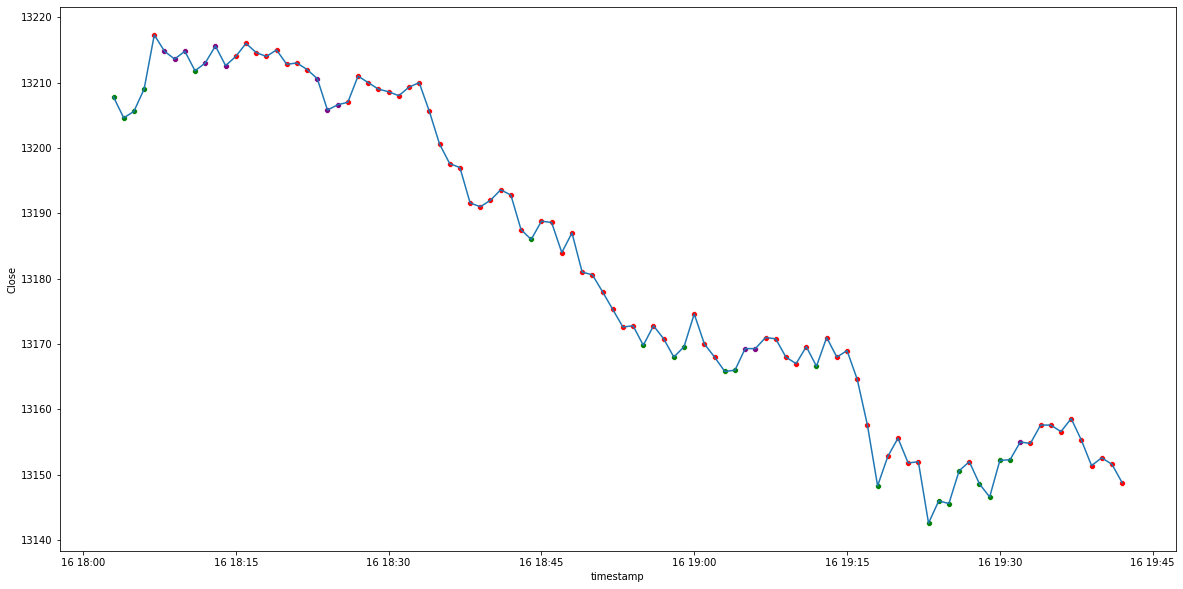

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
plot_actions_in_range(9000,9100)

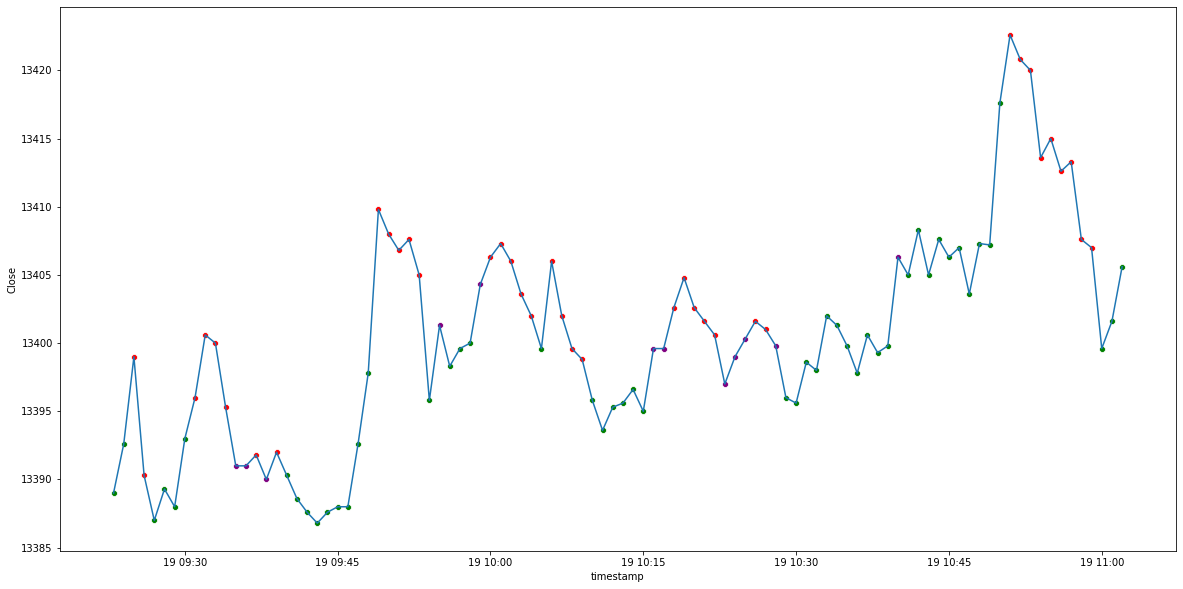

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
plot_actions_in_range(11000,11100)

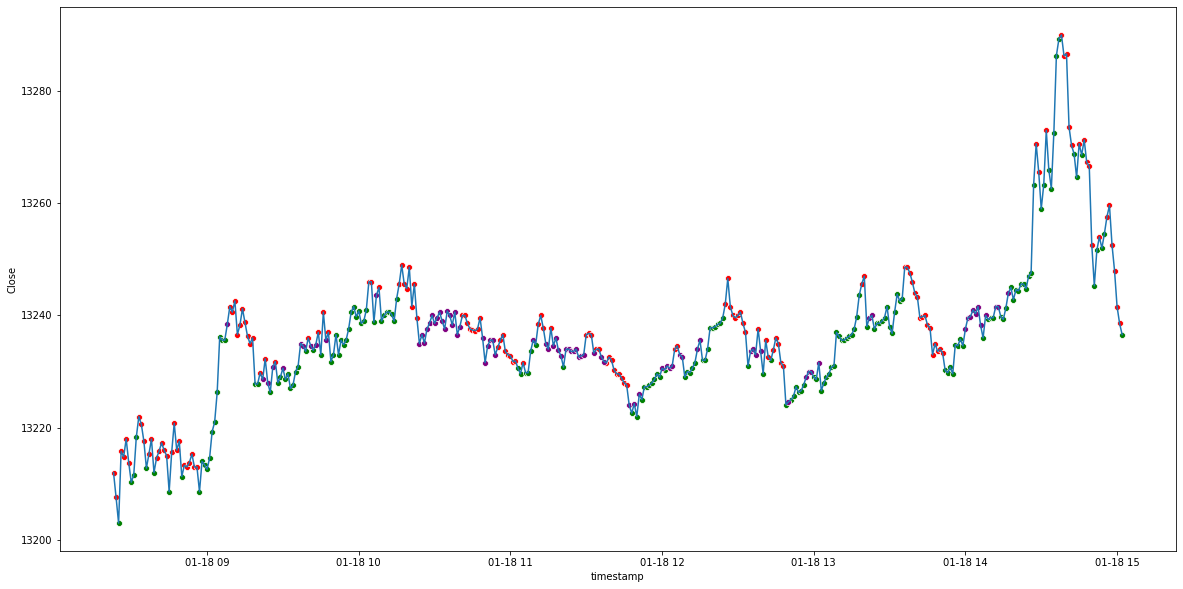

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
plot_actions_in_range(10100,10500)

In [12]:
from sklearn import preprocessing

def normalize(df):
    df_norm = df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    df_norm[['Open','High','Close', 'Low', 'Volume']] = min_max_scaler.fit_transform(df_norm[['Open','High','Close', 'Low', 'Volume']])
    return df_norm

In [13]:
df_norm = normalize(df)
df_norm.head()

,Open,High,Low,Close,Volume,buy,sell,wait
timestamp,,,,,,,,
2018-01-02 07:00:00,0.795346,0.795231,0.794710,0.795840,0.033750,1,0,0
2018-01-02 07:01:00,0.795829,0.798249,0.796427,0.798493,0.035437,0,1,0
2018-01-02 07:02:00,0.798180,0.798068,0.794710,0.794272,0.040499,1,0,0
2018-01-02 07:03:00,0.793990,0.794808,0.794319,0.795086,0.035437,1,0,0
2018-01-02 07:04:00,0.795045,0.795744,0.795704,0.796593,0.017212,1,0,0


In [14]:
df_norm.describe()

,Open,High,Low,Close,Volume,buy,sell,wait
count,409118.000000,409118.000000,409118.000000,409118.000000,409118.000000,409118.000000,409118.000000,409118.000000
mean,0.522510,0.522055,0.522669,0.522577,0.042945,0.356873,0.356496,0.286631
std,0.196339,0.196602,0.196245,0.196385,0.045506,0.479077,0.478965,0.452188
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375068,0.374374,0.375395,0.375098,0.010800,0.000000,0.000000,0.000000
50%,0.551811,0.551343,0.552068,0.551884,0.030037,0.000000,0.000000,0.000000
75%,0.650732,0.650558,0.650721,0.650829,0.059062,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df_train = df_norm[:'2019-05-01']
df_test = df_norm['2019-05-01':]

# Train with only the price

In [16]:
X_train = df_train[['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy()
Y_train = df_train[['buy', 'sell', 'wait']].to_numpy()

X_test = df_test[['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy()
Y_test = df_test[['buy', 'sell', 'wait']].to_numpy()

print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)
print("X test shape:", X_test.shape)
print("Y test shape:", Y_test.shape)

X train shape: (312412, 5)
Y train shape: (312412, 3)
X test shape: (96706, 5)
Y test shape: (96706, 3)


In [17]:
Y_train[0]

array([1, 0, 0], dtype=int64)

In [18]:
# from sklearn.ensemble import GradientBoostingClassifier

# gbc = GradientBoostingClassifier(verbose=1)
# gbc.fit(X_train, Y_train)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(verbose=1, n_estimators=10, n_jobs=10)
rf.fit(X_train, Y_train)
print("Train accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.3s remaining:    5.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.2s finished


Train accuracy: 0.9360555932550606


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy: 0.3230409695365334


In [20]:
rf = RandomForestClassifier(verbose=1, n_estimators=100, n_jobs=10)
rf.fit(X_train, Y_train)
print("Train accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.9s finished


Train accuracy: 0.998834871899927


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished


Test accuracy: 0.35268752714412754


# Add features

In [21]:
from talib import RSI, BBANDS

df['rsi'] = RSI(df['Close'], timeperiod=14)
df['bb_upperband'], df['bb_middleband'], df['bb_lowerband'] = BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df = df.dropna()

In [22]:
def normalize(df):
    df_norm = df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    df_norm[['Open','High','Close', 'Low', 'Volume', 'rsi', 'bb_upperband', 'bb_middleband', 'bb_lowerband']] = min_max_scaler.fit_transform(df_norm[['Open','High','Close', 'Low', 'Volume', 'rsi', 'bb_upperband', 'bb_middleband', 'bb_lowerband']])
    return df_norm

df_norm = normalize(df)
df_norm.head()

,Open,High,Low,Close,Volume,buy,sell,wait,rsi,bb_upperband,bb_middleband,bb_lowerband
timestamp,,,,,,,,,,,,
2018-01-02 07:19:00,0.798843,0.798129,0.798416,0.798794,0.020250,1,0,0,0.558084,0.796390,0.800816,0.800003
2018-01-02 07:20:00,0.798782,0.798672,0.799018,0.799216,0.018225,1,0,0,0.570203,0.796275,0.800986,0.800455
2018-01-02 07:21:00,0.798963,0.799517,0.799620,0.800121,0.015187,0,1,0,0.595990,0.796342,0.801068,0.800551
2018-01-02 07:22:00,0.800109,0.800875,0.800434,0.801206,0.023962,0,1,0,0.625433,0.795985,0.801418,0.801601
2018-01-02 07:23:00,0.800952,0.800241,0.800464,0.800513,0.010125,0,1,0,0.597035,0.795492,0.801691,0.802637


# Train with additionnal features

In [24]:
df_train = df_norm[:'2019-05-01']
df_test = df_norm['2019-05-01':]

In [25]:
X_train = df_train[['Open','High','Close', 'Low', 'Volume', 'rsi', 'bb_upperband', 'bb_middleband', 'bb_lowerband']].to_numpy()
Y_train = df_train[['buy', 'sell', 'wait']].to_numpy()

X_test = df_test[['Open','High','Close', 'Low', 'Volume', 'rsi', 'bb_upperband', 'bb_middleband', 'bb_lowerband']].to_numpy()
Y_test = df_test[['buy', 'sell', 'wait']].to_numpy()

print("X train shape:", X_train.shape)
print("Y train shape:", Y_train.shape)
print("X test shape:", X_test.shape)
print("Y test shape:", Y_test.shape)

X train shape: (312393, 9)
Y train shape: (312393, 3)
X test shape: (96706, 9)
Y test shape: (96706, 3)


In [26]:
rf = RandomForestClassifier(verbose=1, n_estimators=10, n_jobs=10)
rf.fit(X_train, Y_train)
print("Train accuracy:", rf.score(X_train, Y_train))
print("Test accuracy:", rf.score(X_test, Y_test))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    1.9s remaining:    8.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


Train accuracy: 0.9553895253734879


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


Test accuracy: 0.3040452505532232
